In [ ]:
# https://drive.google.com/file/d/1LtTYNmrdi_UFJc06Oby4jbmEqtGsF3aZ/view?usp=sharing

import gdown
file_id = "1LtTYNmrdi_UFJc06Oby4jbmEqtGsF3aZ"
output_file = "ballbeam.dat"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file)

Downloading...
From: https://drive.google.com/uc?id=1LtTYNmrdi_UFJc06Oby4jbmEqtGsF3aZ
To: /content/ballbeam.dat
100%|██████████| 35.0k/35.0k [00:00<00:00, 48.6MB/s]


'ballbeam.dat'

Initializing processing...
Input dimensions: (1000, 2)
Sequence dimensions: (997, 3, 2)
Target dimensions: (997,)
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.1671 - val_loss: 0.1168
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1417 - val_loss: 0.1132
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1373 - val_loss: 0.1103
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1397 - val_loss: 0.1066
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1256 - val_loss: 0.1031
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1058 - val_loss: 0.0998
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1231 - val_loss: 0.0954
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1083 - val_loss: 0.0926
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1059 - val_loss: 0.0889
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1034 - val_loss: 0.0853
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 

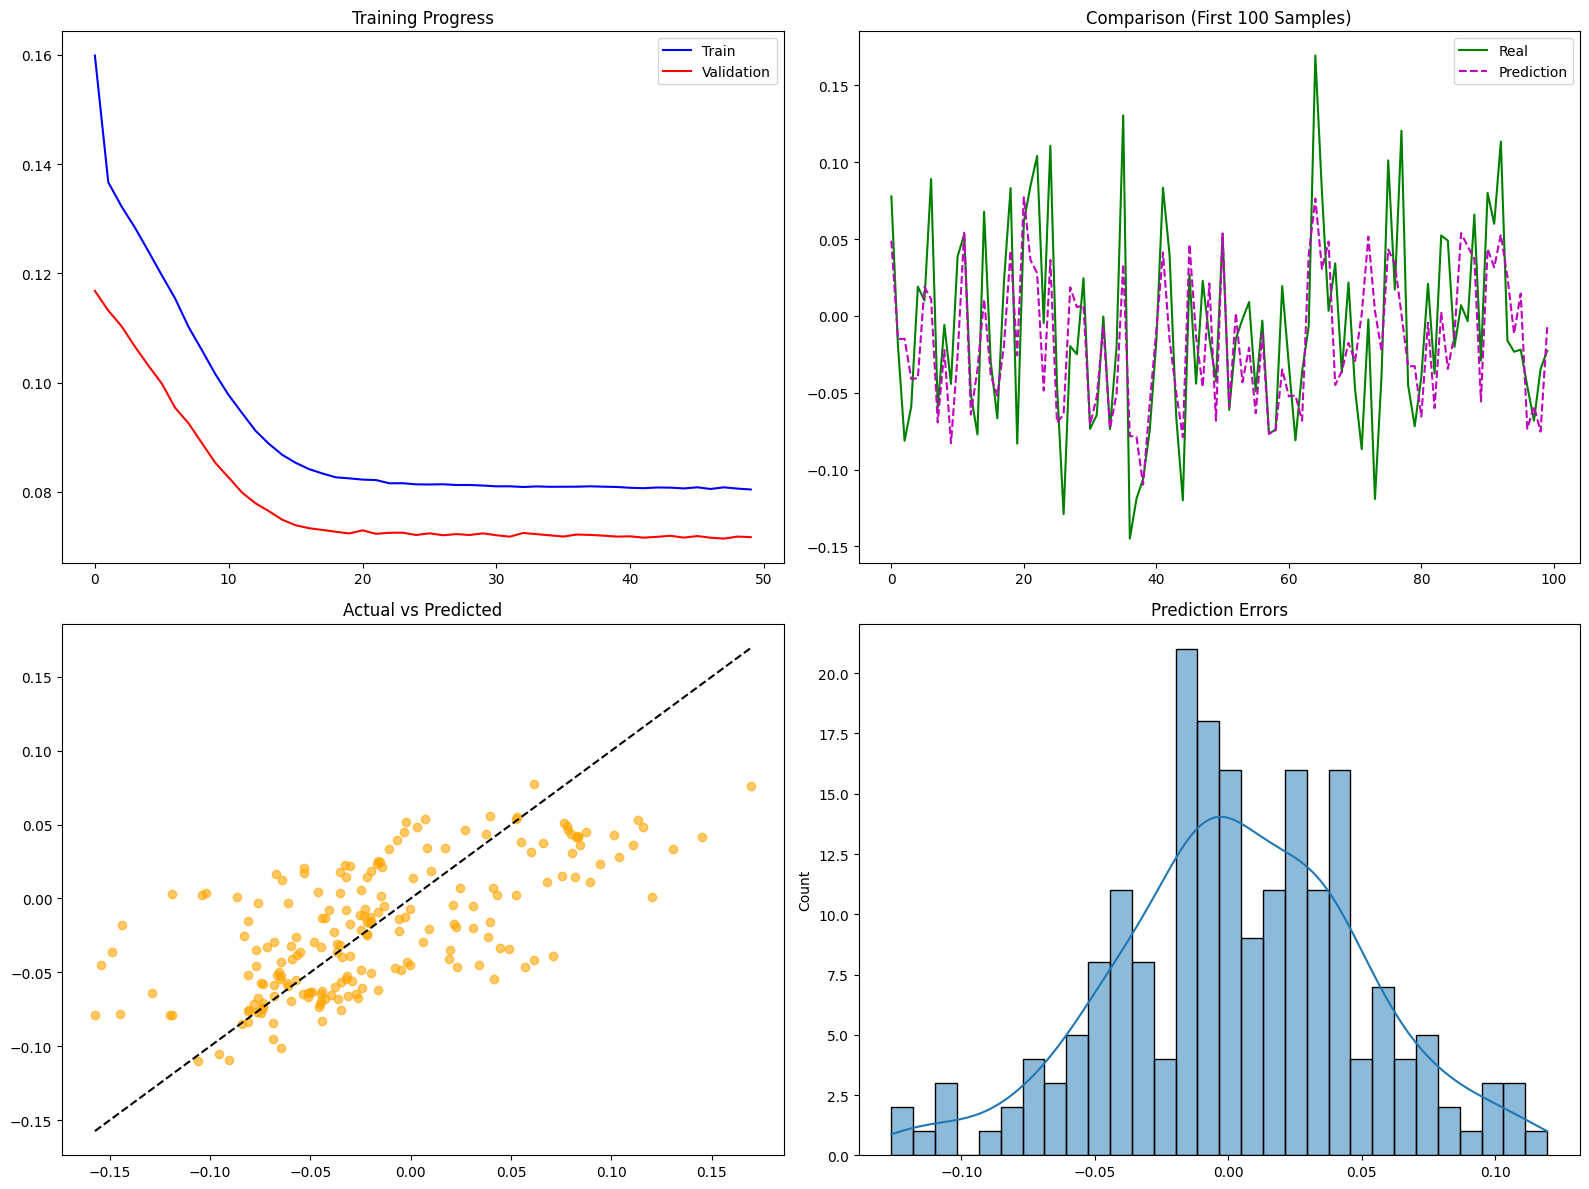


Model Metrics:
MSE: 0.0022
RMSE: 0.0466
MAE: 0.0365


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

class NeuroFuzzyUnit(Layer):
    def __init__(self, n_nodes=3, **kwargs):
        super(NeuroFuzzyUnit, self).__init__(**kwargs)
        self.n_nodes = n_nodes

    def build(self, input_shape):
        dim = input_shape[-1]

        self.centroids = self.add_weight(
            name='centroids',
            shape=(dim, self.n_nodes),
            initializer='glorot_uniform',
            trainable=True
        )

        self.spreads = self.add_weight(
            name='spreads',
            shape=(dim, self.n_nodes),
            initializer='ones',
            trainable=True
        )

        self.coeffs = self.add_weight(
            name='coeffs',
            shape=(dim * self.n_nodes, 1),
            initializer='random_normal',
            trainable=True
        )

    def call(self, X):
        batch = tf.shape(X)[0]
        dim = tf.shape(X)[1]

        X_exp = tf.expand_dims(X, 2)
        delta = X_exp - tf.expand_dims(self.centroids, 0)
        sigma = tf.abs(self.spreads) + 1e-3
        activations = tf.exp(-tf.square(delta)/(2 * sigma))

        flat_act = tf.reshape(activations, [batch, -1])
        return tf.matmul(flat_act, self.coeffs)

def build_network(input_size, n_nodes=3):
    inp = Input(shape=(input_size,))
    neuro_layer = NeuroFuzzyUnit(n_nodes=n_nodes)(inp)
    return tf.keras.Model(inputs=inp, outputs=neuro_layer)

def create_sequences(dataset, window):
    seqs = []
    labels = []
    for i in range(len(dataset)-window):
        seqs.append(dataset[i:i+window])
        labels.append(dataset[i+window, 1])
    return np.array(seqs), np.array(labels)

def process_system(data_file, window=3):
    try:
        raw = np.loadtxt(data_file)
        print("Input dimensions:", raw.shape)

        scaler_x = MinMaxScaler((-1, 1))
        scaler_y = MinMaxScaler((-1, 1))

        processed = np.zeros_like(raw)
        processed[:, 0] = scaler_x.fit_transform(raw[:, 0].reshape(-1, 1)).flatten()
        processed[:, 1] = scaler_y.fit_transform(raw[:, 1].reshape(-1, 1)).flatten()

        X, y = create_sequences(processed, window)
        print("Sequence dimensions:", X.shape)
        print("Target dimensions:", y.shape)

        X_tr, X_te, y_tr, y_te = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        model = build_network(window)
        opt = tf.keras.optimizers.Adam(0.001)
        model.compile(optimizer=opt, loss='mean_squared_error')

        stopper = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

        training_log = model.fit(
            X_tr[:, :, 0],
            y_tr,
            epochs=50,
            batch_size=32,
            validation_data=(X_te[:, :, 0], y_te),
            callbacks=[stopper],
            verbose=1
        )

        preds = model.predict(X_te[:, :, 0])

        y_true = scaler_y.inverse_transform(y_te.reshape(-1, 1)).flatten()
        y_pred = scaler_y.inverse_transform(preds).flatten()

        error = y_true - y_pred
        mse = np.mean(error**2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(error))

        fig = plt.figure(figsize=(16, 12))

        plt.subplot(2, 2, 1)
        plt.plot(training_log.history['loss'], 'b', label='Train')
        plt.plot(training_log.history['val_loss'], 'r', label='Validation')
        plt.title('Training Progress')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(y_true[:100], 'g-', label='Real')
        plt.plot(y_pred[:100], 'm--', label='Prediction')
        plt.title('Comparison (First 100 Samples)')
        plt.legend()

        plt.subplot(2, 2, 3)
        plt.scatter(y_true, y_pred, c='orange', alpha=0.6)
        plt.plot([y_true.min(), y_true.max()],
                [y_true.min(), y_true.max()], 'k--')
        plt.title('Actual vs Predicted')

        plt.subplot(2, 2, 4)
        sns.histplot(error, bins=30, kde=True)
        plt.title('Prediction Errors')

        plt.tight_layout()
        plt.show()

        print('\nModel Metrics:')
        print(f'MSE: {mse:.4f}')
        print(f'RMSE: {rmse:.4f}')
        print(f'MAE: {mae:.4f}')

        return model, training_log, (mse, rmse, mae)

    except Exception as err:
        print(f"Error occurred: {err}")
        return None, None, None

print("Initializing processing...")
data_file = 'ballbeam.dat'
model, log, stats = process_system(data_file)